# Fully-saturated TWFE

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from patsy import dmatrix
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

In [2]:
filepath = '../../../../data/processed/df_filtered.xlsx'
df = pd.read_excel(filepath)

## 階層ベイズモデル 不均一分散

$$
\begin{aligned}
\log{Y^{**}_{it}} &\sim \mathcal{t} (\nu, \mu_{it}, \sigma_i^2) \\
\nu &\sim \text{Exponential}(1/10) \\
\mu_{it} &= \beta_{gl} \cdot T_{i} \\
\beta_{gl} &\sim \mathcal{N}(\mu_{\beta}, \sigma_{\beta}^2) \\
\sigma_i &\sim \mathcal{C}^+(\sigma_0^2) \\
\end{aligned}
$$

- $\beta_{gl}$: 介入時期 $g$ と介入経過時間 $l$ によって変動する介入効果
- $T_{it}$: 介入群ダミー
- $\mu_{\beta}$: 介入時期と介入経過時間の期待値を表すハイパーパラメータ
- $\sigma_{\beta}^2$: 介入時期と介入経過時間の分散を表すハイパーパラメータ
- $\sigma_0^2$: 島間の誤差分散を表すハイパーパラメータ
- $\sigma_i^2$: 島間の誤差分散

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/pymc/model/core.py:1302: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


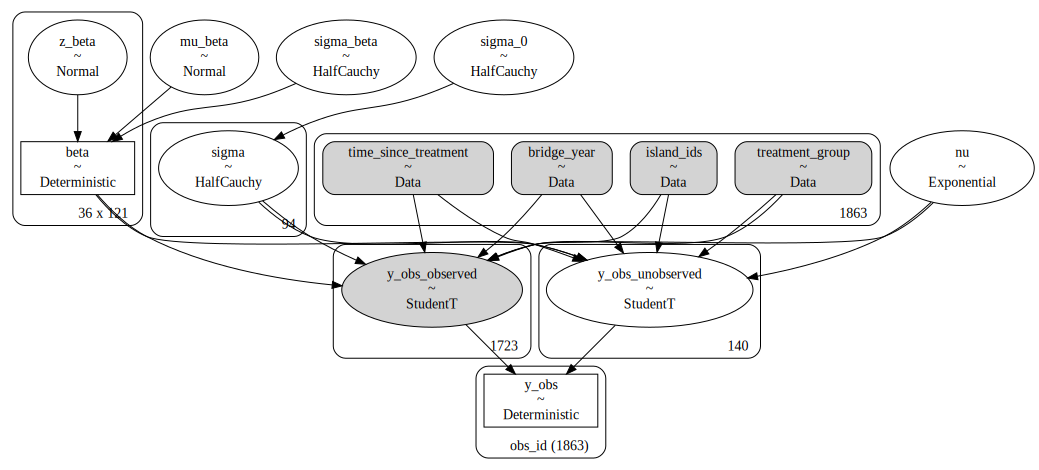

In [3]:
# 0から始まるインデックスを振り直す
island_ids, unique_island_ids = pd.factorize(df['island_ids'])
n_islands = len(unique_island_ids)
bridge_year, unique_bridge_year = pd.factorize(df['bridge_year'])
n_bridge_year = len(unique_bridge_year)
time_since_treatment, unique_time_since_intervention = pd.factorize(df['time_since_treatment'])
n_time_since_intervention = len(unique_time_since_intervention)

COORDS = {'obs_id': df.index}

with pm.Model(coords=COORDS) as model_h_hetero:
    # data
    island_ids = pm.Data('island_ids', island_ids)
    bridge_year = pm.Data('bridge_year', bridge_year)
    treatment_group = pm.Data('treatment_group', df['treatment_group'])
    time_since_treatment = pm.Data('time_since_treatment', time_since_treatment)

    # priors
    # ATT
    mu_beta = pm.Normal('mu_beta', mu=0, sigma=1)
    sigma_beta = pm.HalfCauchy('sigma_beta', beta=1)
    z_beta = pm.Normal('z_beta', mu=0, sigma=1, shape=(n_bridge_year, n_time_since_intervention))
    beta = pm.Deterministic('beta', mu_beta + sigma_beta * z_beta)

    # sigma
    sigma_0 = pm.HalfCauchy('sigma_0', beta=1)
    sigma = pm.HalfCauchy('sigma', beta=sigma_0, shape=n_islands)

    # nu
    nu = pm.Exponential('nu', lam=1/10)

    # expected value
    mu = beta[bridge_year, time_since_treatment] * treatment_group + sigma[island_ids]

    # likelihood
    y_obs = pm.StudentT('y_obs', mu=mu, sigma=sigma[island_ids], nu=nu, observed=df['log_pop_star'], dims='obs_id')

pm.model_to_graphviz(model_h_hetero)

In [ ]:
with model_h_hetero:
    trace_h_hetero = pm.sample(
        draws=3000,
        tune=1000,
        chains=4,
        cores=16,
        nuts_sampler='numpyro',
        random_seed=42
    )

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [20]:
az.summary(trace_h_hetero, var_names=['mu_beta', 'sigma_beta', 'sigma_0', 'nu'], hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_beta,-0.127,0.010,-0.146,-0.108,0.001,0.001,81.0,271.0,1.03
sigma_beta,0.142,0.009,0.124,0.159,0.002,0.001,24.0,211.0,1.11
sigma_0,0.089,0.012,0.066,0.113,0.001,0.001,75.0,697.0,1.05
nu,2.124,0.166,1.817,2.462,0.020,0.014,62.0,524.0,1.06


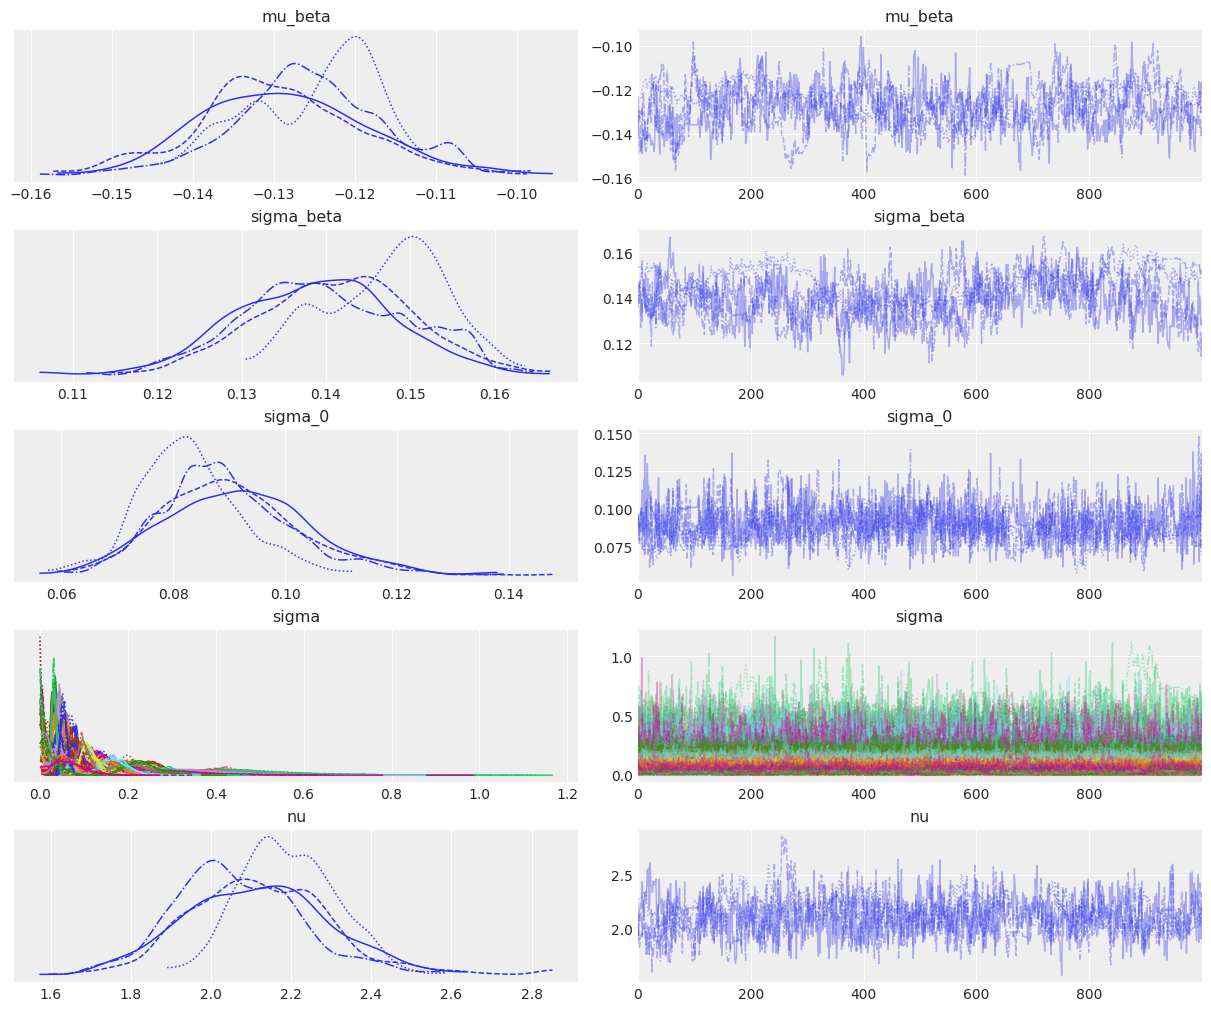

In [21]:
az.plot_trace(trace_h_hetero, var_names=['mu_beta', 'sigma_beta', 'sigma_0', 'sigma', 'nu']);

## 階層ベイズモデル 均一分散

## サンプリングの保存

In [19]:
az.to_netcdf(trace_h_hetero, './mcmc_sample/fully_saturated/trace_h_hetero.nc')

'./sample/trace_fully_saturated_h.nc'